Rayleigh-Taylor instability
======

This notebook models the Rayleigh-Taylor instability outlined in van Keken *et al.* (1997). 

The system of equations is given by

$$
    \nabla \cdot \left( \eta \nabla \dot\varepsilon \right) - \nabla p = -\rho g \mathbf{\hat z}
$$

$$
    \nabla \cdot \mathbf{v} = 0
$$

**Keywords:** particle swarms, Stokes system, advective diffusive systems

**References**

1. van Keken, P.E., S.D. King, H. Schmeling, U.R. Christensen, D.Neumeister and M.-P. Doin. A comparison of methods for the modeling of thermochemical convection. Journal of Geophysical Research, 102, 22,477-22,495, 1997.  
http://onlinelibrary.wiley.com/doi/10.1029/97JB01353/abstract


Please run the cell below if you do not see the interface under the Setup parameters.

In [1]:
#@markdown 
import underworld as uw
from underworld import function as fn
import underworld.visualisation as vis
import math
import numpy as np
import csv
import ipywidgets as widgets
from IPython.display import Javascript, display
import matplotlib.pyplot as plt

def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+3)'))

button = widgets.Button(description="Refresh Setup")
button.on_click(run_all)
display(button)

Button(description='Refresh Setup', style=ButtonStyle())

<IPython.core.display.Javascript object>

Setup Parameters
-----

In [17]:
style = {'description_width': '100px'}

plume = widgets.FloatSlider(0.2, min = 0, max = 1, step = 0.1, description ='plume_thickness', style = style)
slab = widgets.FloatSlider(0.2, min = 0, max = 1, step = 0.1, description ='slab_thickness', style = style)

dens_light = widgets.FloatSlider(2, min = 2, max = 4, step = 0.1, description ='dens_top')
dens_med   = widgets.FloatSlider(1, min = 1, max = 2, step = 0.1, description ='dens_middle')
dens_dense = widgets.FloatSlider(0, min = 0, max = 1, step = 0.1, description ='dens_bottom')

visc_light = widgets.FloatSlider(0.9, min = 0, max = 5, step = 0.1, description ='visc_top')
visc_med   = widgets.FloatSlider(1.0, min = 0, max = 5, step = 0.1, description ='visc_middle')
visc_dense = widgets.FloatSlider(1.1, min = 0, max = 5, step = 0.1, description ='visc_bottom')



# physical parameters

boxLength      = 0.9142
boxHeight      = 1.0
viscosityRatio = 1.0

# output
inputPath  = 'input/05_Rayleigh_Taylor/'
outputPath = 'output/'

# numerical parameters - demo or 'longtest'
# demo       - settings for a quick run (iff longtest is False)
# 'longtest' - settings for benchmark

longtest = False

model_end_time   = 240.
res              = 32
stokes_inner_tol = 1e-6
stokes_outer_tol = 1e-5
# users ignore
import os
if "UW_LONGTEST" in os.environ or longtest:
    # to capture the peak V_rms (benchmark) set model_end_time~220
    # the peak V_rms. 
    res              = 128
    stokes_inner_tol = 1e-7
    stokes_outer_tol = 1e-6


# Make output directory if necessary.
if uw.mpi.rank==0:
    import os
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)


mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))

velocityField = mesh.add_variable(         nodeDofCount=2 )
pressureField = mesh.subMesh.add_variable( nodeDofCount=1 )

# initialise 
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

# Create a swarm.
swarm = uw.swarm.Swarm( mesh=mesh )

# Create a data variable. It will be used to store the material index of each particle.
materialIndex = swarm.add_variable( dataType="int", count=1 )
materialIndex_plot = swarm.add_variable( dataType="int", count=1 )

# Create a layout object, populate the swarm with particles.
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=30 )
swarm.populate_using_layout( layout=swarmLayout )

def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))



button = widgets.Button(description="Run Simulation")
button.on_click(run_all)


# define these for convience. 
lightIndex = 0 
mediumIndex = 1
denseIndex = 2

# material perturbation from van Keken et al. 1997
wavelength = 2.0*boxLength
amplitude  = 0.02 * 4
k = 2. * math.pi / wavelength

# Create function to return particle's coordinate
coord = fn.coord()

def initialise(slab,
               plume,
               dens_light,
               dens_med,
               dens_dense,
               visc_light,
               visc_med,
               visc_dense,              
              ):

    offset_low = plume
    offset_high= 1-slab
    # Define the material perturbation, a function of the x coordinate (accessed by `coord[0]`).
    perturbationFn_low = offset_low + amplitude*fn.math.cos( k*coord[0] )
    perturbationFn_high = offset_high + amplitude*fn.math.cos(k*coord[0] )

    # Setup the conditions list. 
    # If z is less than the perturbation, set to lightIndex.
    conditions = [ (  perturbationFn_high < coord[1],  lightIndex),
                   (  perturbationFn_high > coord[1] > perturbationFn_low, mediumIndex ),
                   (  True, denseIndex ) ]

    # The swarm is passed as an argument to the evaluation, providing evaluation on each particle.
    # Results are written to the materialIndex swarm variable.
    materialIndex.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)
    
    densityMap1   = { lightIndex:dens_light, mediumIndex:dens_med, denseIndex:dens_dense }
    densityFn1   = fn.branching.map( fn_key = materialIndex, mapping = densityMap1 )
    
    viscosityMap1 = { lightIndex:visc_light, mediumIndex:visc_med, denseIndex:visc_dense }
    fn_viscosity  = fn.branching.map( fn_key = materialIndex, mapping = viscosityMap1 )
    
    
    display(button)
    #Plot the particles by material
    fig1 = vis.Figure(title = 'Initial Conditions, density plot')
    fig1.append( vis.objects.Points(swarm, densityFn1, pointSize=2, colourBar=True) )
    fig1.show()
    fig2 = vis.Figure(title = 'Initial Conditions, viscosity plot')
    fig2.append( vis.objects.Points(swarm, fn_viscosity, pointSize=2, colourBar=True, colours = 'brown grey yellow') )
    fig2.show()

    
widgets.interact(initialise,
                 plume = plume,
                 slab = slab,
                 dens_light = dens_light,
                 dens_med = dens_med,
                 dens_dense = dens_dense,
                 visc_light = visc_light,
                 visc_med = visc_med,
                 visc_dense = visc_dense,              
                )


interactive(children=(FloatSlider(value=0.2, description='slab_thickness', max=1.0, style=SliderStyle(descript…

<function __main__.initialise(slab, plume, dens_light, dens_med, dens_dense, visc_light, visc_med, visc_dense)>

Simulation Results
-----

step =      0; time = 0.000e+00; v_rms = 5.300e-04
step =     20; time = 1.460e+02; v_rms = 1.464e-03
step =     40; time = 2.081e+02; v_rms = 2.212e-03
step =     55; time = 2.406e+02; v_rms = 2.299e-03



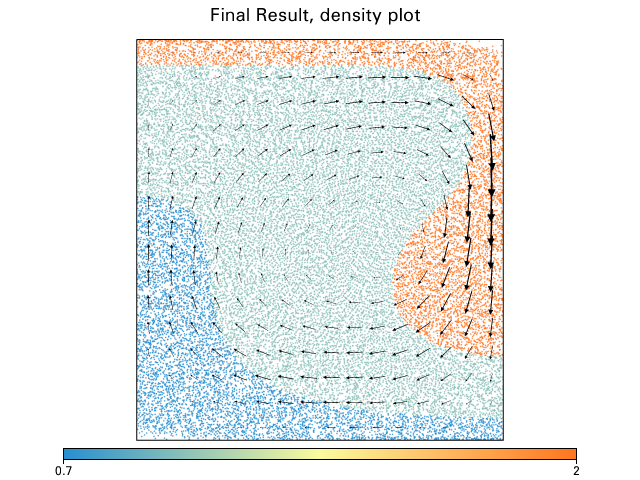

In [16]:
offset_low = plume.value
offset_high= 1 - slab.value
# Define the material perturbation, a function of the x coordinate (accessed by `coord[0]`).
perturbationFn_low = offset_low + amplitude*fn.math.cos( k*coord[0] )
perturbationFn_high = offset_high + amplitude*fn.math.cos(k*coord[0] )

# Setup the conditions list. 
# If z is less than the perturbation, set to lightIndex.
conditions = [ (  perturbationFn_high < coord[1],  lightIndex),
               (  perturbationFn_high > coord[1] > perturbationFn_low, mediumIndex ),
               (  True, denseIndex ) ]

# The swarm is passed as an argument to the evaluation, providing evaluation on each particle.
# Results are written to the materialIndex swarm variable.
materialIndex.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)
densityMap   = { lightIndex:dens_light.value, mediumIndex:dens_med.value, denseIndex:dens_dense.value }
densityFn    = fn.branching.map( fn_key = materialIndex, mapping = densityMap )

# Set a viscosity value of '1.' for both materials.
viscosityMap = { lightIndex:visc_light.value, mediumIndex:visc_med.value, denseIndex:visc_dense.value }
fn_viscosity  = fn.branching.map( fn_key = materialIndex, mapping = viscosityMap )

# Define a vertical unit vector using a python tuple.
z_hat = ( 0.0, 1.0 )

# Create buoyancy force vector
buoyancyFn = -densityFn*z_hat


# Construct node sets using the mesh specialSets
iWalls = mesh.specialSets["Left_VertexSet"]   + mesh.specialSets["Right_VertexSet"]
jWalls = mesh.specialSets["Bottom_VertexSet"] + mesh.specialSets["Top_VertexSet"]
allWalls = iWalls + jWalls

# Prescribe degrees of freedom on each node to be considered Dirichlet conditions.
# In the x direction on allWalls flag as Dirichlet
# In the y direction on jWalls (horizontal) flag as Dirichlet
stokesBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                             indexSetsPerDof = (allWalls, jWalls) )\



stokes = uw.systems.Stokes( velocityField = velocityField, 
                            pressureField = pressureField,
                            conditions    = stokesBC,
                            fn_viscosity  = fn_viscosity, 
                            fn_bodyforce  = buoyancyFn )

solver = uw.systems.Solver( stokes )

# Optional solver settings
if(uw.mpi.size==1):
    solver.set_inner_method("lu")
solver.set_inner_rtol(stokes_inner_tol) 
solver.set_outer_rtol(stokes_outer_tol) 

# Create a system to advect the swarm
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )


# Initialise time and timestep.
time = 0.
step = 0

# parameters for output
outputEvery  = 20
timeVal     = []
vrmsVal     = []

# Save mesh and retain file handle for future xdmf creation
meshFileHandle = mesh.save(outputPath+"Mesh.h5")

# define an update function
def update():
    dt = advector.get_max_dt() # retrieve the maximum possible timestep from the advection system.
    advector.integrate(dt)     # advect step.
    return time+dt, step+1

while time < model_end_time:

    # Get solution
    solver.solve()
    
    # Calculate the RMS velocity.
    vrms = stokes.velocity_rms()

    # Record values into arrays
    if(uw.mpi.rank==0):
        vrmsVal.append(vrms)
        timeVal.append(time)
    
    # Output to disk
    if step%outputEvery == 0:
        if(uw.mpi.rank==0):
            print('step = {0:6d}; time = {1:.3e}; v_rms = {2:.3e}'.format(step,time,vrms))

        filename = outputPath+"/velocityField."+str(step)
        vFH      = velocityField.save(filename+".h5")
        velocityField.xdmf( filename, vFH, "velocity", meshFileHandle, "Mesh", time )
        
        filename = outputPath+"/pressureField."+str(step)
        pFH      = pressureField.save(filename+".h5")
        pressureField.xdmf(filename, pFH, "pressure", meshFileHandle, "Mesh", time )
        
        outputFilename = outputPath+"image"+str(step).zfill(4)
#         fig1.save_image(outputFilename)

    # We are finished with current timestep, update.
    time, step = update()
    
if(uw.mpi.rank==0):
    print('step = {0:6d}; time = {1:.3e}; v_rms = {2:.3e}'.format(step,time,vrms))

fig1 = vis.Figure(title = 'Final Result, density plot')
fig1.append( vis.objects.Points(swarm, densityFn, pointSize=2, colourBar=True) )
fig1.append( vis.objects.VectorArrows( mesh, velocityField))
fig1.show()